In [11]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import json
import yaml
import tempfile
import streamlit as st

from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFLoader
from langchain.vectorstores import Chroma
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI
from dotenv import load_dotenv
from sentence_transformers import SentenceTransformer
from chromadb import Embeddings
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough

from unstructured.partition.auto import partition


In [12]:
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_KEY")
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

with open('data/prompt_template.yaml', 'r') as file:
    loaded_templates = yaml.safe_load(file)

### Prompt

In [94]:
# The prompt template as a Python dictionary
loaded_templates = {
    "cv-parsing-prompt": """
        You are an expert in human resources and your job is to extract relevant information from curriculums.
        For each experience in the curriculum, you should return a json containing the following information:
        - Experiences: List of experiences containing relevant fields.
            - job_title: Associated job title
            - description: Description of the role
            - skills: List of skills mentioned
        - Languages: List of languages known by the candidate.
        - Highlights: Brief summary of the candidate's profile.
        - Education: Granted degrees and certifications.

        Here is the curriculum:
        ```
        {cv}
        ```
        The response should be only a json.
    """,


    "job-offer-processing-prompt": """
        Please use a retriever to find job offers similar to the following: "Job Offer: {joboffer}"

        In the results, I would like you to:
        1. Highlight the key responsibilities and qualifications of the given job offer and spesify. 
        2. Identify and summarize the skills and qualifications that are commonly sought in similar job offers.

        1. Job Offer Summary:
        - Title: 
        - Department: 
        - Responsibilities:
        - Qualifications:
        - Skills and Proficiencies:
        - Educational Background:

        2. Commonly Sought Skills and Qualifications:
        - Educational Background: 
        - Experience: 
        - Skills: 
        - Technical Proficiencies: 
        - Regulatory Knowledge: 
        - Certifications: 

        Note: The specific requirements and preferences for qualifications may vary between job offers.

        Please return the information in the JSON format.
        """,


    "full-report-template": """
        I have a curriculum vitae (CV) and a job offer. I would like you to compare the two and provide insights on how well the CV matches the job offer's requirements. Please use a retriever to consult the ESCO (European Skills, Competences, Qualifications and Occupations) Taxonomy to extract relevant job profile information. This will inform a more accurate comparison between the CV and the job offer.
        Be concise and objective.
        Curriculum Vitae:
        ```
        {cv}
        ```

        Job Offer:
        ```
        {job_offer}
        ```
        Instructions for the OpenAI model:
            1. Use the ESCO Taxonomy to find job profiles that correspond with the experiences and qualifications listed in the CV.
            2. Critically evaluate the relevance of each experience and qualification in the CV against the specific requirements of the job offer.
            3. Focus on the precise nature of the job offer, considering the essential qualifications, detailed responsibilities, and the level of expertise required.
            4. Provide a realistic analysis that identifies:
            - Direct matches and transferable skills between the CV and the job offer.
            - Any qualifications or experiences in the CV that are exactly what the job offer requires.
            - Areas where the CV falls short of the job offer's requirements, including lack of specific experiences, necessary qualifications, or required certifications.
            5. Avoid using expressions that directly affect the decision, are subjective and dominant. Be concrete and clear, explain your thoughts in a transparent way.

        Return the analysis in the following JSON structure:
        {{
            "ESCO Analysis": {{
                "Educational Qualifications Comparison": "",
                "Skills and Proficiencies Match": "",
                "Certifications and Regulatory Knowledge": "",
                "Job Profile Match": "",
                "Overall Summary": {{
                    "Strong Matches": "",
                    "Potential Gaps": ""
                }}
            }}
        }}

        Note: The insights should be based on the retrieved information from the ESCO Taxonomy to ensure an informed and accurate analysis.
        """
}


### Revoke Functions

In [46]:
MODEL_NAME = 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2'
class SentenceTransformerEmbeddings(Embeddings):
    def __init__(self, model_name):
        self._embedding_function = SentenceTransformer(model_name)
    def embed_documents(self, texts):
        embeddings = self._embedding_function.encode(texts, convert_to_numpy=True).tolist()
        return [list(map(float, e)) for e in embeddings]
    def embed_query(self, text):
        embeddings = self._embedding_function.encode([text], convert_to_numpy=True).tolist()
        return [list(map(float, e)) for e in embeddings][0]

sentence_transformer_ef = SentenceTransformerEmbeddings(MODEL_NAME)

In [47]:
persist_ESCO_vectorstore = Chroma(persist_directory="ESCO_mpnet_db", embedding_function=sentence_transformer_ef)
persist_JobOffers_vectorstore = Chroma(persist_directory="mpnet_embeddings_db", embedding_function=sentence_transformer_ef)

In [66]:
llm = ChatOpenAI()

#### Parse CV

In [269]:
cv_file_path = "data/example_cv_2.pdf"
job_offer_file_path = "data/Job_Offer.pdf"

In [42]:
# loader = PyPDFLoader(tmp_file_path, extract_images=True)
# cv = loader.load()
# cv

In [270]:
elements = partition(filename=cv_file_path)
cv = [str(el) for el in elements]
# print("\n\n".join([str(el) for el in elements]))

In [271]:
prompt_template = loaded_templates['cv-parsing-prompt'].strip()
prompt = ChatPromptTemplate.from_template(prompt_template)
            
chain = prompt | llm | StrOutputParser()
response = chain.invoke({"cv": cv})
processed_cv_output = json.loads(response)

In [272]:
processed_cv_output

{'Experiences': [{'job_title': 'Digital Marketing Specialist',
   'description': 'Manage digital sales and streaming accounts to improve brand positioning and growth. Source and develop new strategic partnerships, social engagements, and advertising opportunities that generate new revenue streams. Collaborate with internal departments to execute national advertising campaigns, plan global digital distribution, and re-deploy a 1M+ consumer sales and marketing database.',
   'skills': []},
  {'job_title': 'Digital Marketing Associate',
   'description': 'Worked with management to develop and apply digital marketing plans with a focus on driving acquisition and conversion. Devised and implemented robust digital acquisition plans, ensuring precision in financial reporting, budgets, and forecasts. Increased conversions by 15% from paid sources (PPC, Grant, Display, and VOD). Enhanced conversion rates by 12% via A/B testing landing pages for a better performing conversion funnel.',
   'skill

#### Process Job Offer

In [275]:
# job_offer = 'We are seeking a dynamic individual to be a part of our Audit department. As our auditor, your responsibilities will include planning and performing a variety of internal audits and special projects throughout the company, which include a variety of Senior Manage- ment driven assignments. These audits will include detailed assessment of operational, financial and systems activities where a thorough understanding of control processes must be obtained from a variety of people and resources. Candidate should hold degree in either finance, bussiness analytics, engineering'
elements = partition(filename=job_offer_file_path)
job_offer = [str(el) for el in elements]
job_offer 

['Requisitos',
 'Estudios mínimos',
 'Diplomatura',
 'Experiencia mínima',
 'Al menos 3 años',
 'Descripción',
 'Buscamos a un/a Crack del Marketing Online para formar parte de nuestro equipo de consultores',
 'senior de marketing digital.',
 'Trabajando en la empresa más innovadora en marketing Digital, La Incubadora Despegue.',
 'Esta oportunidad puede ser para ti si:',
 'Buscas un sitio donde el valor nº1 del trabajo es el crecimiento profesional.',
 'Aprender es uno de los pilares más importantes, no solo para tu carrera profesional si no también',
 'a nivel personal.',
 'Tienes experiencia estratégica y/o táctica en marketing Digital y es un área que te apasiona.',
 'Lo tuyo son metodologías y sistemas, eres capaz de seguir un sistema que funciona',
 'implementarlo a la perfección.',
 'Trabajar cada día, mano a mano, con empresarios para ayudarles a crecer sus ventas es el',
 'trabajo perfecto para ti.',
 'Tu carrera profesional ahora mismo es tu máxima prioridad.',
 'Si te siente

In [251]:
vectorstore = persist_JobOffers_vectorstore
retriever = vectorstore.as_retriever()

prompt_template = loaded_templates['job-offer-processing-prompt'].strip()
prompt = ChatPromptTemplate.from_template(prompt_template)
chain = (
    {"context": retriever, "joboffer": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)
response = chain.invoke({"joboffer":job_offer})
processed_job_offer_output = json.loads(response)

In [254]:
processed_job_offer_output

{'Job Offer Summary': {'Title': 'Sales Manager',
  'Department': 'Sales',
  'Responsibilities': 'Lead and support sales team: mentoring, motivating, training, developing/executing sales strategies, and directing the mission of the department. Develop new business opportunities: define, refine, test, and implement new business development by means of marketing, networking, cold calling, referral, and other sales techniques. Spearhead the development of sound marketing strategies in order to stimulate product sales and build brand recognition. Meet or exceed established monthly, quarterly, and annual sales goals. Develop quarterly and annual sales projections. Maintain an ongoing knowledge of our core signage, display and visual marketing product line. Significant opportunity for career advancement exists for the candidate that demonstrates a strong work ethic and produces quantifiable results.',
  'Qualifications': "Current or previous experience in a signage or graphics related industr

#### Full Report

In [57]:
vectorstore = persist_ESCO_vectorstore
retriever = vectorstore.as_retriever()
prompt_template = loaded_templates['full-report-template'].strip()
prompt = ChatPromptTemplate.from_template(prompt_template)
# Select the frst experience
# cv = json.loads(json.dumps(st.session_state['processed_cv_output']['Experiences'][0]))
cv = processed_cv_output
job_offer = processed_job_offer_output
chain = (
    {"context": retriever, "cv": RunnablePassthrough(), "job_offer": RunnablePassthrough()}
    | prompt 
    | llm
)
answer = chain.invoke({"cv": cv, "job_offer": job_offer})
response = json.loads(answer.content)

In [58]:
print(json.dumps(response, indent=2))

{
  "ESCO Analysis": {
    "Educational Qualifications Comparison": "The job offer requires a Bachelor's degree in accounting, finance, or a related field. The CV does not mention any educational qualifications, so there is a gap in this requirement.",
    "Skills and Proficiencies Match": "The CV lists skills such as customer services, Microsoft Office, team collaboration, retail operations, and complaints resolution. While some of these skills may be transferable to the role of an Auditor, there is a lack of specific skills required for auditing, such as strong analytical and problem-solving skills, attention to detail, and proficiency in accounting software and MS Office Suite. Therefore, there is a gap in this requirement.",
    "Certifications and Regulatory Knowledge": "The job offer mentions professional certifications such as Certified Internal Auditor (CIA) or Certified Public Accountant (CPA). The CV does not mention any certifications, so there is a gap in this requirement."

### Generate Scores

In [277]:
cv = processed_cv_output
job_offer = processed_job_offer_output
# cv, job_offer

#### Education Match

In [129]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_education_similarity(cv, job_offer):
    vectors = sentence_transformer_ef.embed_documents([cv, job_offer])
    cos_sim = cosine_similarity(vectors)
    return cos_sim[0][1]

cv_education, job_offer_education = cv['Education'][0]['degree'], job_offer['Job Offer Summary']['Educational Background']
cos_similarity = compute_education_similarity(cv, job_offer)
cos_similarity

0.7055225305537178

In [122]:
from Levenshtein import distance as levenshtein_distance
levenshtein_dist = levenshtein_distance(cv_education, job_offer_education)
levenshtein_dist


27

In [130]:
# # Function to normalize the Levenshtein distance into a similarity score between 0 and 1
# def normalize_levenshtein_distance(distance, length_of_longer_string):
#     if length_of_longer_string == 0:  # To handle the case where both strings might be empty
#         return 1
#     return 1 - (distance / length_of_longer_string)

# # Using the maximum possible length of the two strings as the normalizing factor
# max_length = max(len(cv_education), len(job_offer_education))
# normalized_levenshtein_similarity = normalize_levenshtein_distance(levenshtein_dist, max_length)

# # Combine the normalized Levenshtein similarity score and the cosine similarity score
# # For simplicity, we take an unweighted average of the two scores here
# combined_score = (normalized_levenshtein_similarity + cosine_sim_score) / 2

# normalized_levenshtein_similarity, combined_score


In [131]:
cv['Education'][0]['degree']



'Bachelor of Arts, Communications'

In [100]:
job_offer['Job Offer Summary']['Educational Background']

'Diplomatura'

#### Similar Job Titles


In [279]:
experiences = cv['Experiences']
experiences[0]

{'job_title': 'Digital Marketing Specialist',
 'description': 'Manage digital sales and streaming accounts to improve brand positioning and growth. Source and develop new strategic partnerships, social engagements, and advertising opportunities that generate new revenue streams. Collaborate with internal departments to execute national advertising campaigns, plan global digital distribution, and re-deploy a 1M+ consumer sales and marketing database.',
 'skills': []}

In [389]:
weights = [1, 2, 3, 4]  # for example, if you have 4 experiences
weights = [-1 * number for number in weights]

def compute_esco_similarity(document, weight, k):
    # Function to perform weighted similarity search
    def weighted_similarity_search(doc, weight):
        vectorstore = persist_ESCO_vectorstore
        results = vectorstore.similarity_search_with_score(doc, k, include_metadata=True)
        results = [{"page_content": r[0].page_content, "score": r[1]} for r in results]
        # Multiply relevance scores by weight to give more importance to certain experiences
        for result in results:
            result['weighted_score'] = result['score']# * weight
        return results

    # Perform similarity search for each experience with corresponding weight
    all_results = []
    for doc, weight in zip(document, weights):
        results = weighted_similarity_search(doc, weight)
        all_results.extend(results)

    # Sort all results based on the weighted score
    all_results.sort(key=lambda x: x['weighted_score'], reverse=True)

    # Select the top 5 most relevant documents
    return all_results
cv_top_5_esco_occupations = compute_esco_similarity(experiences, weights, k=20)
cv_similar_esco_with_scores = [(result['page_content'].split(';'[0])[0].split(" :"[1])[1].strip(),  result['score'], ) for result in cv_top_5_esco_occupations]


In [388]:
vectorstore = persist_JobOffers_vectorstore
jo_top_5_esco_occupations = vectorstore.similarity_search_with_score("Social Media Manager", k=1000, include_metadata=True)

jo_similar_esco_with_scores = [(result[0].page_content.split(';'[0])[0].split(" :"[1])[1].strip(),  result[1], ) for result in jo_top_5_esco_occupations]
jo_similar_esco_with_scores = [(title.lower().strip(), score, ) for title, score in jo_similar_esco_with_scores]

In [390]:
# def normalize_scores_separately(cv_scores, job_offer_scores):
#     # Combine all scores to establish the range
#     all_scores = [score for _, score in cv_scores] + [score for _, score in job_offer_scores]
#     min_score, max_score = min(all_scores), max(all_scores)

#     # Normalize the scores
#     cv_normalized = [(title, (score - min_score) / (max_score - min_score)) for title, score in cv_scores]
#     job_offer_normalized = [(title, (score - min_score) / (max_score - min_score)) for title, score in job_offer_scores]

#     return cv_normalized, job_offer_normalized

# def find_common_titles_and_normalise_scores(cv_data, job_offer_data):
#     # Extract titles from both datasets
#     cv_titles = set([title for title, _ in cv_data])
#     job_offer_titles = set([title for title, _ in job_offer_data])

#     # Combine all scores to establish the range
#     all_scores = [score for _, score in cv_data] + [score for _, score in job_offer_data]
#     min_score, max_score = min(all_scores), max(all_scores)
#     # Normalize the scores
#     cv_normalized = [(title, (score - min_score) / (max_score - min_score)) for title, score in cv_data]
#     job_offer_normalized = [(title, (score - min_score) / (max_score - min_score)) for title, score in job_offer_data]
    
#     # cv_data = { title: score for title, score in zip(cv_titles, cv_normalized)}
#     # job_offer_data = { title: score for title, score in zip(job_offer_titles, job_offer_normalized)}

#     # Find the intersection of titles
#     common_titles = cv_titles.intersection(job_offer_titles)
#     return common_titles, cv_normalized, job_offer_normalized

# # Usage:
# cv_data = cv_similar_esco_with_scores
# job_offer_data = jo_similar_esco_with_scores


# # Find common titles
# common_titles, cv_normalized, job_offer_normalized = find_common_titles(cv_data, job_offer_data)




#### Skills

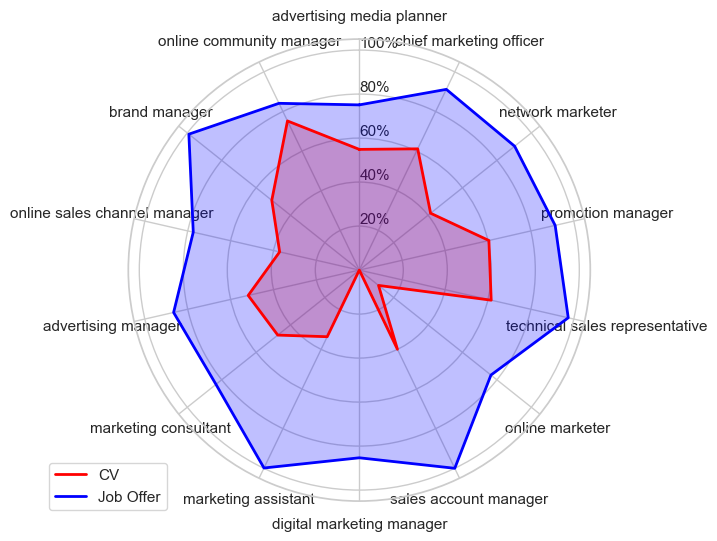

In [393]:
import matplotlib.pyplot as plt
import numpy as np

# data
cv_data = cv_similar_esco_with_scores
job_offer_data = jo_similar_esco_with_scores

def plot_esco_matched_job_titles(cv_data, job_offer_data):
    # Find common titles
    common_titles = set(title for title, _ in cv_data) & set(title for title, _ in job_offer_data)

    # Combine all scores to establish the range
    all_scores = [score for title, score in cv_data if title in common_titles] + \
                [score for title, score in job_offer_data if title in common_titles]
    min_score, max_score = min(all_scores), max(all_scores)

    # Normalize the scores separately
    cv_normalized = {title: (score - min_score) / (max_score - min_score)
                    for title, score in cv_data if title in common_titles}
    job_offer_normalized = {title: (score - min_score) / (max_score - min_score)
                            for title, score in job_offer_data if title in common_titles}

    # Prepare data for the spider chart
    labels = list(common_titles)
    cv_scores = [cv_normalized[title] for title in labels]
    job_offer_scores = [job_offer_normalized[title] for title in labels]


    # Number of variables
    num_vars = len(labels)

    # Compute angle each bar is centered on:
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The plot is made circular, so we need to "complete the loop" and append the start to the end.
    cv_scores += cv_scores[:1]
    job_offer_scores += job_offer_scores[:1]
    angles += angles[:1]

    # Draw the spider chart
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    # Draw one line per variable and add labels
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], labels)

    # Draw ylabels
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8, 1.0], labels=['20%', '40%', '60%', '80%', '100%'], angle=angles[0])

    # Plot data
    ax.plot(angles, cv_scores, color='red', linewidth=2, linestyle='solid', label='CV')
    ax.fill(angles, cv_scores, color='red', alpha=0.25)

    ax.plot(angles, job_offer_scores, color='blue', linewidth=2, linestyle='solid', label='Job Offer')
    ax.fill(angles, job_offer_scores, color='blue', alpha=0.25)

    # Add a legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    # Show the plot
    plt.show()
# plot_esco_matched_job_titles(cv_data, job_offer_data)

### Vis

/var/folders/hz/jfqn6dnx7qxdgl_fsqhmm8940000gn/T/ipykernel_44509/1862037728.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=education_labels, y=education_values, palette=education_colors)
/var/folders/hz/jfqn6dnx7qxdgl_fsqhmm8940000gn/T/ipykernel_44509/1862037728.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=certifications_labels, y=certifications_presence, palette=certifications_colors, ax=ax)


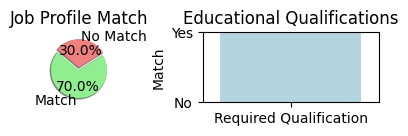

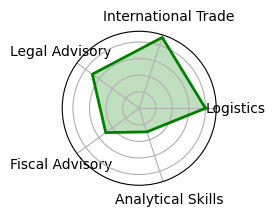

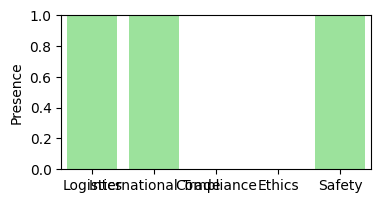

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Re-defining mock data for demonstration purposes since the previous environment state is lost

# Function Output for Job Profile Match
job_profile_match_score = 70  # Mock score as percentage

# Function Output for Educational Qualifications
education_match = True  # Mock output indicating the presence of the required degree

# Function Output for Skills And Proficiencies
skills_scores = {
    "Logistics": 0.8,
    "International Trade": 0.9,
    "Legal Advisory": 0.7,
    "Fiscal Advisory": 0.5,
    "Analytical Skills": 0.3,
}

# Function Output for Certifications And Regulatory Knowledge
certifications_presence = [True, True, False, False, True]  # Mock data for presence of certifications

# Visualizations

# Job Profile Match - Gauge Chart (Mocked with Pie Chart for demonstration)
profile_match_labels = 'Match', 'No Match'
profile_match_sizes = [job_profile_match_score, 100 - job_profile_match_score]
profile_match_colors = ['lightgreen', 'lightcoral']
profile_match_explode = (0.1, 0)

# Educational Qualifications - Bar Graph
education_labels = ['Required Qualification']
education_values = [1 if education_match else 0]
education_colors = ['lightblue' if education_match else 'lightcoral']

# Skills And Proficiencies - Spider Chart
labels = np.array(list(skills_scores.keys()))
stats = np.array(list(skills_scores.values()))

# Certifications And Regulatory Knowledge - Binary Bar Graph
certifications_labels = ['Logistics', 'International Trade', 'Compliance', 'Ethics', 'Safety']
certifications_colors = ['lightgreen' if val else 'lightcoral' for val in certifications_presence]

# Start plotting
plt.figure(figsize=(5, 2))

# Gauge Chart for job profile match
plt.subplot(221, aspect='equal')
plt.pie(profile_match_sizes, explode=profile_match_explode, labels=profile_match_labels, colors=profile_match_colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Job Profile Match')

# Bar Graph for educational qualifications
plt.subplot(222)
sns.barplot(x=education_labels, y=education_values, palette=education_colors)
plt.title('Educational Qualifications')
plt.ylim(0, 1)
plt.ylabel('Match')
plt.yticks([0, 1], ['No', 'Yes'])

# Spider Chart for skills and proficiencies
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
stats = np.concatenate((stats,[stats[0]]))  # Ensure the plot is a closed circle
angles += angles[:1]  # Ensure the plot is a closed circle

fig, ax = plt.subplots(figsize=(2, 2), subplot_kw=dict(polar=True))
ax.fill(angles, stats, color='green', alpha=0.25)
ax.plot(angles, stats, color='green', linewidth=2)  
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

# Setup bar chart for Certifications and Regulatory Knowledge
fig, ax = plt.subplots(figsize=(4, 2))
sns.barplot(x=certifications_labels, y=certifications_presence, palette=certifications_colors, ax=ax)
ax.set_ylabel('Presence')
ax.set_ylim(0, 1)

# Show all plots
plt.show()